In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# unzipping the saved model file

!unzip -q /kaggle/input/model-gravityspy-64-5/model_64_5.h5

[/kaggle/input/model-gravityspy-64-5/model_64_5.h5]
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of /kaggle/input/model-gravityspy-64-5/model_64_5.h5 or
        /kaggle/input/model-gravityspy-64-5/model_64_5.h5.zip, and cannot find /kaggle/input/model-gravityspy-64-5/model_64_5.h5.ZIP, period.


In [3]:
# importing the required Python modules

import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

# defining the model architecture used for training

model = Sequential([
    Conv2D(filters=32, kernel_size=(5,5), input_shape=(384,384,1), activation='relu'),
    MaxPooling2D((2,2)),
    layers.Dropout(0.2),
    Conv2D(filters=64, kernel_size=(5,5), activation='relu'),
    MaxPooling2D((2,2)),
    layers.Dropout(0.2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(22, activation='softmax')
])

2024-07-21 15:28:42.974008: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-21 15:28:42.974166: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-21 15:28:43.130973: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [4]:
# compiling the model

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [5]:
# code to load the model weights
model.load_weights('/kaggle/input/model-gravityspy-64-5/model_64_5.h5')

In [6]:
# testing the performance of trained model on unseen data using test data of Gravity Spy in a very different setting. Keeping the image size and color combination consistent

test_dir = '/kaggle/input/test-dataset-1/content/test/test'
test_set = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels = 'inferred',
    label_mode='int',
    color_mode = 'grayscale',
    batch_size = 64,
    image_size = (384,384),
    shuffle = True,
)

Found 4720 files belonging to 22 classes.


In [7]:
test_target = test_set.class_names
print(test_target)

['1080Lines', '1400Ripples', 'Air_Compressor', 'Blip', 'Chirp', 'Extremely_Loud', 'Helix', 'Koi_Fish', 'Light_Modulation', 'Low_Frequency_Burst', 'Low_Frequency_Lines', 'No_Glitch', 'None_of_the_Above', 'Paired_Doves', 'Power_Line', 'Repeating_Blips', 'Scattered_Light', 'Scratchy', 'Tomte', 'Violin_Mode', 'Wandering_Line', 'Whistle']


In [8]:
# normalization of pixels similar to training and validation sets

def normalization(image, label):
    image = tf.cast(image, tf.float16)/255.0
    return image, label

test_set = test_set.map(normalization)
test_set

<_MapDataset element_spec=(TensorSpec(shape=(None, 384, 384, 1), dtype=tf.float16, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [9]:
'''
Code to predict the images into one of the 22 target classes. 
'''

y_test = []
y_pred = []

# Iterate over batches of test data and collect true and predicted labels
for images, labels in test_set:
    predictions = model.predict(images, verbose=0)
    y_pred.extend(np.argmax(predictions, axis=1))
    y_test.extend(labels.numpy())

# Convert lists to numpy arrays
y_test = np.array(y_test)
y_pred = np.array(y_pred)

In [10]:
print(y_test, y_pred)

[ 3 14  7 ...  3  3  7] [ 3 14  7 ...  3  3  7]


In [11]:
y_pred.shape, y_test.shape

((4720,), (4720,))

Confusion Matrix and Classification report to assess the performance of the model on test data (unseen data) in a totally independent setting.

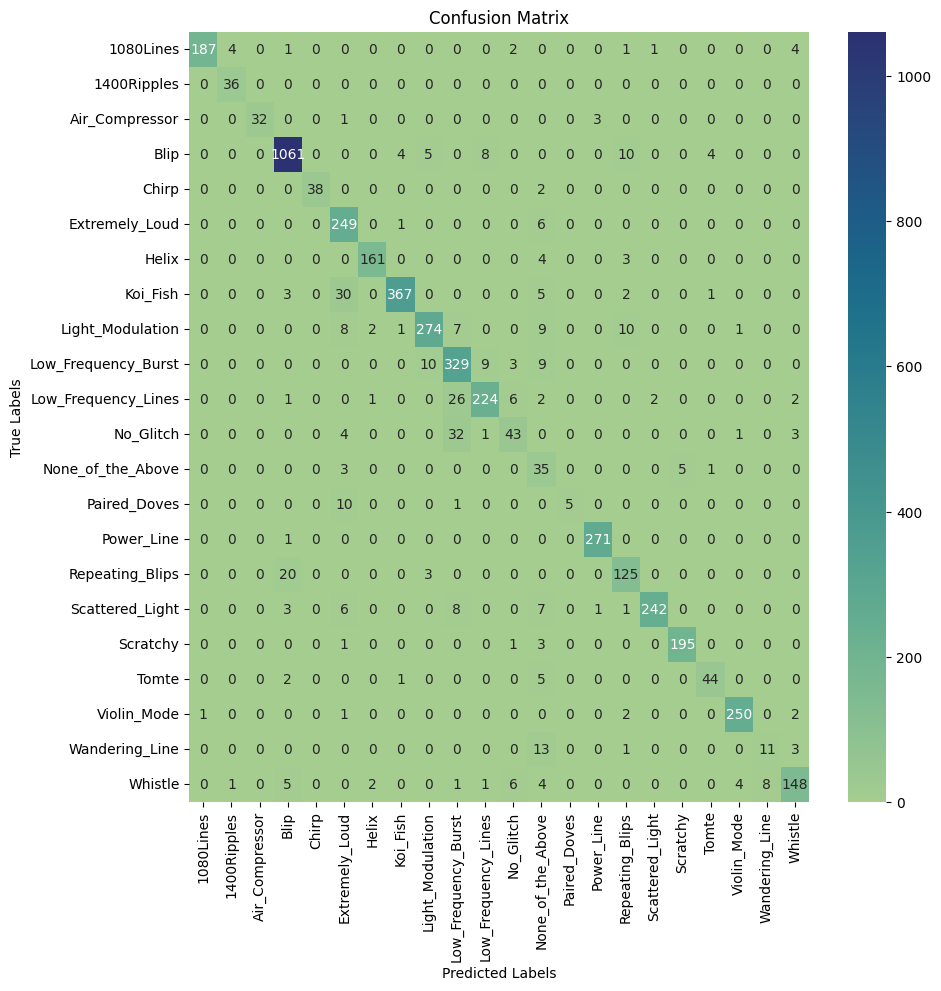

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='crest', xticklabels=test_target, yticklabels=test_target)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(rotation=90)  # Rotate x-axis labels if they are too long
plt.title('Confusion Matrix')
plt.show()

In [13]:
# classification report
report = classification_report(y_test, y_pred, target_names=test_target)
print("Classification Report:")
print(report)

Classification Report:
                     precision    recall  f1-score   support

          1080Lines       0.99      0.94      0.96       200
        1400Ripples       0.88      1.00      0.94        36
     Air_Compressor       1.00      0.89      0.94        36
               Blip       0.97      0.97      0.97      1092
              Chirp       1.00      0.95      0.97        40
     Extremely_Loud       0.80      0.97      0.88       256
              Helix       0.97      0.96      0.96       168
           Koi_Fish       0.98      0.90      0.94       408
   Light_Modulation       0.94      0.88      0.91       312
Low_Frequency_Burst       0.81      0.91      0.86       360
Low_Frequency_Lines       0.92      0.85      0.88       264
          No_Glitch       0.70      0.51      0.59        84
  None_of_the_Above       0.34      0.80      0.47        44
       Paired_Doves       1.00      0.31      0.48        16
         Power_Line       0.99      1.00      0.99       272
